In [79]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from iso639 import languages
import user_agents
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo
import requests
import json
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from datasist.structdata import detect_outliers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder 
from datetime import datetime
from sklearn.model_selection import cross_validate,cross_val_score,cross_val_predict,train_test_split,GridSearchCV,RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import r2_score , mean_squared_error , classification_report ,recall_score , precision_score , ConfusionMatrixDisplay , confusion_matrix
from sklearn.linear_model import Ridge , Lasso
from sklearn.tree import DecisionTreeRegressor , DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.svm import SVC , SVR
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering,KMeans,DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector,SelectFromModel
%matplotlib inline


In [2]:
#import data
raw_data=pd.read_excel('../data/interim/Data_Train.xlsx' )
df=raw_data.copy()
df.sample(5)

Airline Date_of_Journey   Source Destination  \
2260   Jet Airways       1/04/2019  Kolkata    Banglore   
10133     Air Asia       1/05/2019  Kolkata    Banglore   
9682        IndiGo       1/06/2019  Chennai     Kolkata   
7850      Air Asia       9/03/2019  Kolkata    Banglore   
9072   Jet Airways      21/03/2019    Delhi      Cochin   

                       Route Dep_Time  Arrival_Time Duration Total_Stops  \
2260         CCU → BOM → BLR    16:30  16:20 02 Apr  23h 50m      1 stop   
10133              CCU → BLR    19:55         22:25   2h 30m    non-stop   
9682               MAA → CCU    19:35         21:55   2h 20m    non-stop   
7850               CCU → BLR    10:20         12:55   2h 35m    non-stop   
9072   DEL → BDQ → BOM → COK    10:45  18:50 22 Mar   32h 5m     2 stops   

                   Additional_Info  Price  
2260   In-flight meal not included   7064  
10133                      No info   5989  
9682                       No info   3597  
7850                       No info   4384  
9072   In-flight meal not included   9270

In [3]:
#cleansing
#investing
df.shape

(10683, 11)

In [4]:
df.describe().T

count         mean          std     min     25%     50%      75%  \
Price  10683.0  9087.064121  4611.359167  1759.0  5277.0  8372.0  12373.0   

           max  
Price  79512.0

In [5]:
df.describe(include='O').T

count unique              top  freq
Airline          10683     12      Jet Airways  3849
Date_of_Journey  10683     44       18/05/2019   504
Source           10683      5            Delhi  4537
Destination      10683      6           Cochin  4537
Route            10682    128  DEL → BOM → COK  2376
Dep_Time         10683    222            18:55   233
Arrival_Time     10683   1343            19:00   423
Duration         10683    368           2h 50m   550
Total_Stops      10682      5           1 stop  5625
Additional_Info  10683     10          No info  8345

In [6]:
df.describe(include='all').T

count unique              top  freq         mean  \
Airline            10683     12      Jet Airways  3849          NaN   
Date_of_Journey    10683     44       18/05/2019   504          NaN   
Source             10683      5            Delhi  4537          NaN   
Destination        10683      6           Cochin  4537          NaN   
Route              10682    128  DEL → BOM → COK  2376          NaN   
Dep_Time           10683    222            18:55   233          NaN   
Arrival_Time       10683   1343            19:00   423          NaN   
Duration           10683    368           2h 50m   550          NaN   
Total_Stops        10682      5           1 stop  5625          NaN   
Additional_Info    10683     10          No info  8345          NaN   
Price            10683.0    NaN              NaN   NaN  9087.064121   

                         std     min     25%     50%      75%      max  
Airline                  NaN     NaN     NaN     NaN      NaN      NaN  
Date_of_Journey          NaN     NaN     NaN     NaN      NaN      NaN  
Source                   NaN     NaN     NaN     NaN      NaN      NaN  
Destination              NaN     NaN     NaN     NaN      NaN      NaN  
Route                    NaN     NaN     NaN     NaN      NaN      NaN  
Dep_Time                 NaN     NaN     NaN     NaN      NaN      NaN  
Arrival_Time             NaN     NaN     NaN     NaN      NaN      NaN  
Duration                 NaN     NaN     NaN     NaN      NaN      NaN  
Total_Stops              NaN     NaN     NaN     NaN      NaN      NaN  
Additional_Info          NaN     NaN     NaN     NaN      NaN      NaN  
Price            4611.359167  1759.0  5277.0  8372.0  12373.0  79512.0

In [7]:
df.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [9]:
#check duplicates
df.duplicated().sum()

220

In [10]:
#handle duplicates
df.drop_duplicates(inplace=True,ignore_index=True)
df.duplicated().sum()

0

In [11]:
#check missing value
df.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [12]:
#check ratio of missing values
df.isna().sum()/df.shape[0] * 100

Airline            0.000000
Date_of_Journey    0.000000
Source             0.000000
Destination        0.000000
Route              0.009557
Dep_Time           0.000000
Arrival_Time       0.000000
Duration           0.000000
Total_Stops        0.009557
Additional_Info    0.000000
Price              0.000000
dtype: float64

In [13]:
#handle na values
df.dropna(inplace=True)
df

Airline Date_of_Journey    Source Destination  \
0           IndiGo      24/03/2019  Banglore   New Delhi   
1        Air India       1/05/2019   Kolkata    Banglore   
2      Jet Airways       9/06/2019     Delhi      Cochin   
3           IndiGo      12/05/2019   Kolkata    Banglore   
4           IndiGo      01/03/2019  Banglore   New Delhi   
...            ...             ...       ...         ...   
10458     Air Asia       9/04/2019   Kolkata    Banglore   
10459    Air India      27/04/2019   Kolkata    Banglore   
10460  Jet Airways      27/04/2019  Banglore       Delhi   
10461      Vistara      01/03/2019  Banglore   New Delhi   
10462    Air India       9/05/2019     Delhi      Cochin   

                       Route Dep_Time  Arrival_Time Duration Total_Stops  \
0                  BLR → DEL    22:20  01:10 22 Mar   2h 50m    non-stop   
1      CCU → IXR → BBI → BLR    05:50         13:15   7h 25m     2 stops   
2      DEL → LKO → BOM → COK    09:25  04:25 10 Jun      19h     2 stops   
3            CCU → NAG → BLR    18:05         23:30   5h 25m      1 stop   
4            BLR → NAG → DEL    16:50         21:35   4h 45m      1 stop   
...                      ...      ...           ...      ...         ...   
10458              CCU → BLR    19:55         22:25   2h 30m    non-stop   
10459              CCU → BLR    20:45         23:20   2h 35m    non-stop   
10460              BLR → DEL    08:20         11:20       3h    non-stop   
10461              BLR → DEL    11:30         14:10   2h 40m    non-stop   
10462  DEL → GOI → BOM → COK    10:55         19:15   8h 20m     2 stops   

      Additional_Info  Price  
0             No info   3897  
1             No info   7662  
2             No info  13882  
3             No info   6218  
4             No info  13302  
...               ...    ...  
10458         No info   4107  
10459         No info   4145  
10460         No info   7229  
10461         No info  12648  
10462         No info  11753  

[10462 rows x 11 columns]

In [14]:
#check columns
#rename columns
df.columns=df.columns.str.lower().str.strip().str.replace(" ","_")
df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'route',
       'dep_time', 'arrival_time', 'duration', 'total_stops',
       'additional_info', 'price'],
      dtype='object')

In [15]:
#check rows 
#check unique id and logic
#check object
#no object features exist
for i in  df.select_dtypes('object'):
    print(f'for {i} : \n',df[i].value_counts())
    print('-'*60)

for airline : 
 Jet Airways                          3700
IndiGo                               2043
Air India                            1694
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: airline, dtype: int64
------------------------------------------------------------
for date_of_journey : 
 6/06/2019     490
18/05/2019    486
9/06/2019     485
12/06/2019    483
21/05/2019    482
9/05/2019     466
21/03/2019    412
15/05/2019    402
27/05/2019    369
27/06/2019    339
24/06/2019    330
1/06/2019     330
3/06/2019     326
15/06/2019    314
24/03/2019    314
6/03/2019     302
27/03/2019    290
24/05/2019    286
6/05/2019     281
1/05/2019     274
12/05/2

In [16]:
#feature engineering
#there is no web users nor geospatial feature

In [17]:
#data and time features
df['date_of_journey']=pd.to_datetime(df['date_of_journey'],errors='coerce')

In [18]:
df['year']=df['date_of_journey'].dt.year
df['month']=df['date_of_journey'].dt.month
df['day']=df['date_of_journey'].dt.day
df['day_name']=df['date_of_journey'].dt.day_name()

In [19]:
df.drop('date_of_journey',axis=1,inplace=True)

In [20]:
df

airline    source destination                  route dep_time  \
0           IndiGo  Banglore   New Delhi              BLR → DEL    22:20   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR    05:50   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK    09:25   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR    18:05   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL    16:50   
...            ...       ...         ...                    ...      ...   
10458     Air Asia   Kolkata    Banglore              CCU → BLR    19:55   
10459    Air India   Kolkata    Banglore              CCU → BLR    20:45   
10460  Jet Airways  Banglore       Delhi              BLR → DEL    08:20   
10461      Vistara  Banglore   New Delhi              BLR → DEL    11:30   
10462    Air India     Delhi      Cochin  DEL → GOI → BOM → COK    10:55   

       arrival_time duration total_stops additional_info  price  year  month  \
0      01:10 22 Mar   2h 50m    non-stop         No info   3897  2019      3   
1             13:15   7h 25m     2 stops         No info   7662  2019      1   
2      04:25 10 Jun      19h     2 stops         No info  13882  2019      9   
3             23:30   5h 25m      1 stop         No info   6218  2019     12   
4             21:35   4h 45m      1 stop         No info  13302  2019      1   
...             ...      ...         ...             ...    ...   ...    ...   
10458         22:25   2h 30m    non-stop         No info   4107  2019      9   
10459         23:20   2h 35m    non-stop         No info   4145  2019      4   
10460         11:20       3h    non-stop         No info   7229  2019      4   
10461         14:10   2h 40m    non-stop         No info  12648  2019      1   
10462         19:15   8h 20m     2 stops         No info  11753  2019      9   

       day   day_name  
0       24     Sunday  
1        5   Saturday  
2        6     Friday  
3        5   Thursday  
4        3   Thursday  
...    ...        ...  
10458    4  Wednesday  
10459   27   Saturday  
10460   27   Saturday  
10461    3   Thursday  
10462    5   Thursday  

[10462 rows x 14 columns]

In [21]:
#string operation
#replace any airline with less than 100 trips (threshold) with 'other' string
freq=df['airline'].value_counts().reset_index()

In [22]:
freq

index  airline
0                         Jet Airways     3700
1                              IndiGo     2043
2                           Air India     1694
3                   Multiple carriers     1196
4                            SpiceJet      815
5                             Vistara      478
6                            Air Asia      319
7                               GoAir      194
8   Multiple carriers Premium economy       13
9                Jet Airways Business        6
10            Vistara Premium economy        3
11                             Trujet        1

In [23]:
threshold_airline=freq[freq['airline'] < 100 ]['index'].values
threshold_airline=list(threshold_airline)
threshold_airline

['Multiple carriers Premium economy',
 'Jet Airways Business',
 'Vistara Premium economy',
 'Trujet']

In [24]:
def edit_airline(x):
    if x in threshold_airline :
        return 'other'
    else :
        return x
df['airline']=df['airline'].apply(edit_airline)    

In [25]:
df

airline    source destination                  route dep_time  \
0           IndiGo  Banglore   New Delhi              BLR → DEL    22:20   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR    05:50   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK    09:25   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR    18:05   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL    16:50   
...            ...       ...         ...                    ...      ...   
10458     Air Asia   Kolkata    Banglore              CCU → BLR    19:55   
10459    Air India   Kolkata    Banglore              CCU → BLR    20:45   
10460  Jet Airways  Banglore       Delhi              BLR → DEL    08:20   
10461      Vistara  Banglore   New Delhi              BLR → DEL    11:30   
10462    Air India     Delhi      Cochin  DEL → GOI → BOM → COK    10:55   

       arrival_time duration total_stops additional_info  price  year  month  \
0      01:10 22 Mar   2h 50m    non-stop         No info   3897  2019      3   
1             13:15   7h 25m     2 stops         No info   7662  2019      1   
2      04:25 10 Jun      19h     2 stops         No info  13882  2019      9   
3             23:30   5h 25m      1 stop         No info   6218  2019     12   
4             21:35   4h 45m      1 stop         No info  13302  2019      1   
...             ...      ...         ...             ...    ...   ...    ...   
10458         22:25   2h 30m    non-stop         No info   4107  2019      9   
10459         23:20   2h 35m    non-stop         No info   4145  2019      4   
10460         11:20       3h    non-stop         No info   7229  2019      4   
10461         14:10   2h 40m    non-stop         No info  12648  2019      1   
10462         19:15   8h 20m     2 stops         No info  11753  2019      9   

       day   day_name  
0       24     Sunday  
1        5   Saturday  
2        6     Friday  
3        5   Thursday  
4        3   Thursday  
...    ...        ...  
10458    4  Wednesday  
10459   27   Saturday  
10460   27   Saturday  
10461    3   Thursday  
10462    5   Thursday  

[10462 rows x 14 columns]

In [26]:
#check day , month and year logic
df[['year','month','day']].describe().T

count         mean       std     min     25%     50%     75%     max
year   10462.0  2019.000000  0.000000  2019.0  2019.0  2019.0  2019.0  2019.0
month  10462.0     5.534601  2.995344     1.0     3.0     5.0     6.0    12.0
day    10462.0    12.630090  8.791635     3.0     5.0     6.0    21.0    27.0

In [27]:
df['day_name'].describe(include='O').T

count        10462
unique           7
top       Thursday
freq          2231
Name: day_name, dtype: object

In [28]:
#transfer total stops into numeric int values
def edit_total_stops(x):
    if x == 'non-stop':
        return int(0)
    elif x == '1 stop' :
        return int(x.split('stop')[0]) 
    else :
        return int (x.split('stops')[0])
#test it with random string
edit_total_stops('5 stops')
edit_total_stops('non-stop')

0

In [29]:
df['total_stops']=df['total_stops'].apply(edit_total_stops)
df

airline    source destination                  route dep_time  \
0           IndiGo  Banglore   New Delhi              BLR → DEL    22:20   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR    05:50   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK    09:25   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR    18:05   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL    16:50   
...            ...       ...         ...                    ...      ...   
10458     Air Asia   Kolkata    Banglore              CCU → BLR    19:55   
10459    Air India   Kolkata    Banglore              CCU → BLR    20:45   
10460  Jet Airways  Banglore       Delhi              BLR → DEL    08:20   
10461      Vistara  Banglore   New Delhi              BLR → DEL    11:30   
10462    Air India     Delhi      Cochin  DEL → GOI → BOM → COK    10:55   

       arrival_time duration  total_stops additional_info  price  year  month  \
0      01:10 22 Mar   2h 50m            0         No info   3897  2019      3   
1             13:15   7h 25m            2         No info   7662  2019      1   
2      04:25 10 Jun      19h            2         No info  13882  2019      9   
3             23:30   5h 25m            1         No info   6218  2019     12   
4             21:35   4h 45m            1         No info  13302  2019      1   
...             ...      ...          ...             ...    ...   ...    ...   
10458         22:25   2h 30m            0         No info   4107  2019      9   
10459         23:20   2h 35m            0         No info   4145  2019      4   
10460         11:20       3h            0         No info   7229  2019      4   
10461         14:10   2h 40m            0         No info  12648  2019      1   
10462         19:15   8h 20m            2         No info  11753  2019      9   

       day   day_name  
0       24     Sunday  
1        5   Saturday  
2        6     Friday  
3        5   Thursday  
4        3   Thursday  
...    ...        ...  
10458    4  Wednesday  
10459   27   Saturday  
10460   27   Saturday  
10461    3   Thursday  
10462    5   Thursday  

[10462 rows x 14 columns]

In [30]:
#domian knowledge feature with string operation
df['duration'].value_counts()


2h 50m     544
1h 30m     386
2h 45m     335
2h 55m     332
2h 35m     329
          ... 
30h 25m      1
30h 15m      1
42h 5m       1
28h 55m      1
47h 40m      1
Name: duration, Length: 368, dtype: int64

In [31]:
def edit_duration_hours(x):
    if x == '5m':
        return int (0.083)
    else :
        return int(x.split('h')[0])
df['duration_hours']=df['duration'].apply(edit_duration_hours)
df

airline    source destination                  route dep_time  \
0           IndiGo  Banglore   New Delhi              BLR → DEL    22:20   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR    05:50   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK    09:25   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR    18:05   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL    16:50   
...            ...       ...         ...                    ...      ...   
10458     Air Asia   Kolkata    Banglore              CCU → BLR    19:55   
10459    Air India   Kolkata    Banglore              CCU → BLR    20:45   
10460  Jet Airways  Banglore       Delhi              BLR → DEL    08:20   
10461      Vistara  Banglore   New Delhi              BLR → DEL    11:30   
10462    Air India     Delhi      Cochin  DEL → GOI → BOM → COK    10:55   

       arrival_time duration  total_stops additional_info  price  year  month  \
0      01:10 22 Mar   2h 50m            0         No info   3897  2019      3   
1             13:15   7h 25m            2         No info   7662  2019      1   
2      04:25 10 Jun      19h            2         No info  13882  2019      9   
3             23:30   5h 25m            1         No info   6218  2019     12   
4             21:35   4h 45m            1         No info  13302  2019      1   
...             ...      ...          ...             ...    ...   ...    ...   
10458         22:25   2h 30m            0         No info   4107  2019      9   
10459         23:20   2h 35m            0         No info   4145  2019      4   
10460         11:20       3h            0         No info   7229  2019      4   
10461         14:10   2h 40m            0         No info  12648  2019      1   
10462         19:15   8h 20m            2         No info  11753  2019      9   

       day   day_name  duration_hours  
0       24     Sunday               2  
1        5   Saturday               7  
2        6     Friday              19  
3        5   Thursday               5  
4        3   Thursday               4  
...    ...        ...             ...  
10458    4  Wednesday               2  
10459   27   Saturday               2  
10460   27   Saturday               3  
10461    3   Thursday               2  
10462    5   Thursday               8  

[10462 rows x 15 columns]

In [36]:
def edit_duration_minutes(x):
    if x.split('h')[-1] =='' :
        return int(0)
    else :
        return int(x.split('h')[-1].strip().strip('m'))
df['duration_monutes']=df['duration'].apply(edit_duration_minutes)
df

airline    source destination                  route dep_time  \
0           IndiGo  Banglore   New Delhi              BLR → DEL    22:20   
1        Air India   Kolkata    Banglore  CCU → IXR → BBI → BLR    05:50   
2      Jet Airways     Delhi      Cochin  DEL → LKO → BOM → COK    09:25   
3           IndiGo   Kolkata    Banglore        CCU → NAG → BLR    18:05   
4           IndiGo  Banglore   New Delhi        BLR → NAG → DEL    16:50   
...            ...       ...         ...                    ...      ...   
10458     Air Asia   Kolkata    Banglore              CCU → BLR    19:55   
10459    Air India   Kolkata    Banglore              CCU → BLR    20:45   
10460  Jet Airways  Banglore       Delhi              BLR → DEL    08:20   
10461      Vistara  Banglore   New Delhi              BLR → DEL    11:30   
10462    Air India     Delhi      Cochin  DEL → GOI → BOM → COK    10:55   

       arrival_time duration  total_stops additional_info  price  year  month  \
0      01:10 22 Mar   2h 50m            0         No info   3897  2019      3   
1             13:15   7h 25m            2         No info   7662  2019      1   
2      04:25 10 Jun      19h            2         No info  13882  2019      9   
3             23:30   5h 25m            1         No info   6218  2019     12   
4             21:35   4h 45m            1         No info  13302  2019      1   
...             ...      ...          ...             ...    ...   ...    ...   
10458         22:25   2h 30m            0         No info   4107  2019      9   
10459         23:20   2h 35m            0         No info   4145  2019      4   
10460         11:20       3h            0         No info   7229  2019      4   
10461         14:10   2h 40m            0         No info  12648  2019      1   
10462         19:15   8h 20m            2         No info  11753  2019      9   

       day   day_name  duration_hours  duration_monutes  
0       24     Sunday               2                50  
1        5   Saturday               7                25  
2        6     Friday              19                 0  
3        5   Thursday               5                25  
4        3   Thursday               4                45  
...    ...        ...             ...               ...  
10458    4  Wednesday               2                30  
10459   27   Saturday               2                35  
10460   27   Saturday               3                 0  
10461    3   Thursday               2                40  
10462    5   Thursday               8                20  

[10462 rows x 16 columns]

In [37]:
#replace any routes with less than 100 trips (threshold) with 'other' string
freq=df['route'].value_counts().reset_index()

In [38]:
freq

index  route
0          DEL → BOM → COK   2376
1                BLR → DEL   1536
2          CCU → BOM → BLR    979
3                CCU → BLR    724
4                BOM → HYD    621
..                     ...    ...
123        CCU → VTZ → BLR      1
124  CCU → IXZ → MAA → BLR      1
125  BOM → COK → MAA → HYD      1
126        BOM → CCU → HYD      1
127        BOM → BBI → HYD      1

[128 rows x 2 columns]

In [39]:
threshold_route=freq[freq['route'] < 100 ]['index'].values
threshold_route=list(threshold_route)
threshold_route

['DEL → IDR → BOM → COK',
 'DEL → HYD → MAA → COK',
 'CCU → MAA → BLR',
 'CCU → HYD → BLR',
 'CCU → BBI → BLR',
 'DEL → BHO → BOM → COK',
 'CCU → IXR → DEL → BLR',
 'DEL → HYD → BOM → COK',
 'DEL → NAG → BOM → COK',
 'DEL → CCU → BOM → COK',
 'DEL → GOI → BOM → COK',
 'DEL → PNQ → COK',
 'CCU → BBI → BOM → BLR',
 'CCU → GAU → BLR',
 'DEL → LKO → BOM → COK',
 'DEL → ATQ → BOM → COK',
 'CCU → GAU → DEL → BLR',
 'DEL → JDH → BOM → COK',
 'BLR → HYD → DEL',
 'BOM → DEL → HYD',
 'CCU → BOM → COK → BLR',
 'BLR → MAA → DEL',
 'CCU → DEL → COK → BLR',
 'DEL → BDQ → BOM → COK',
 'DEL → AMD → COK',
 'CCU → DEL → AMD → BLR',
 'CCU → IXB → BLR',
 'CCU → PNQ → BLR',
 'DEL → UDR → BOM → COK',
 'BLR → AMD → DEL',
 'DEL → LKO → COK',
 'DEL → TRV → COK',
 'BLR → COK → DEL',
 'DEL → RPR → NAG → BOM → COK',
 'CCU → BOM → GOI → BLR',
 'CCU → JAI → BOM → BLR',
 'DEL → IXU → BOM → COK',
 'DEL → MAA → BOM → COK',
 'BLR → CCU → DEL',
 'CCU → AMD → BLR',
 'BLR → CCU → GAU → DEL',
 'DEL → IXC → BOM → COK',
 'BL

In [40]:
def edit_route(x):
    if x in threshold_route :
        return 'other'
    else :
        return x
df['route']=df['route'].apply(edit_route)    

In [43]:
freq=df['additional_info'].value_counts().reset_index()
freq

index  additional_info
0                       No info             8182
1   In-flight meal not included             1926
2  No check-in baggage included              318
3                1 Long layover               19
4               Change airports                7
5                Business class                4
6                       No Info                3
7               1 Short layover                1
8                Red-eye flight                1
9                2 Long layover                1

In [45]:
threshold_info=freq[freq['additional_info'] < 20 ]['index'].values
threshold_info=list(threshold_info)
threshold_info

['1 Long layover',
 'Change airports',
 'Business class',
 'No Info',
 '1 Short layover',
 'Red-eye flight',
 '2 Long layover']

In [46]:
def edit_info(x):
    if x in threshold_info :
        return 'other'
    elif x == 'No Info':
        return 'No info'
    else :
        return x
df['additional_info']=df['additional_info'].apply(edit_info)
df['additional_info'].value_counts()

No info                         8182
In-flight meal not included     1926
No check-in baggage included     318
other                             36
Name: additional_info, dtype: int64

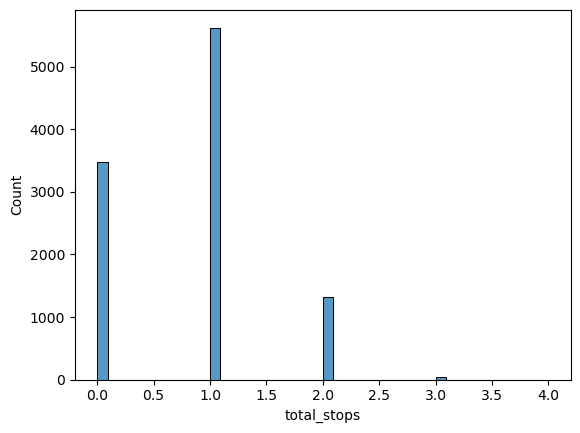

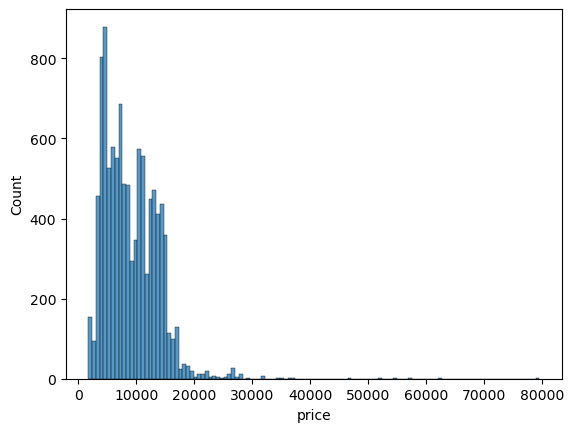

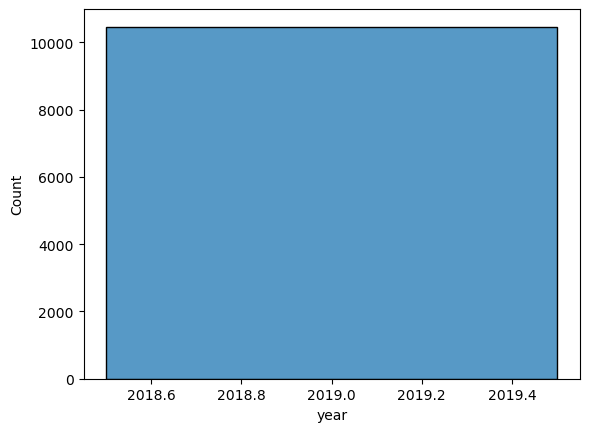

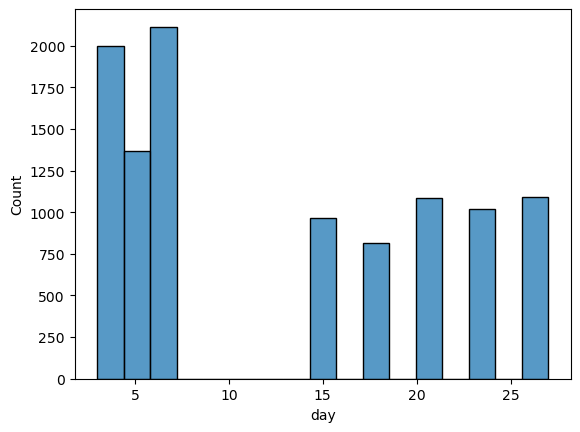

<Figure size 640x480 with 0 Axes>

In [51]:
#univariet analysis
#numeric features
for i in df.select_dtypes(include='number').columns:
    sns.histplot(x=df[i])
    plt.figure()
print()    

after logging the values : 



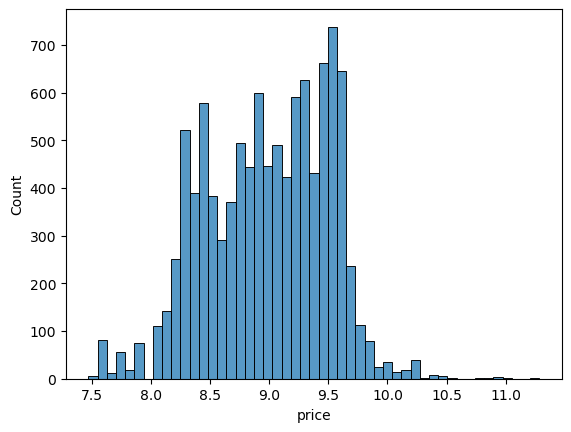

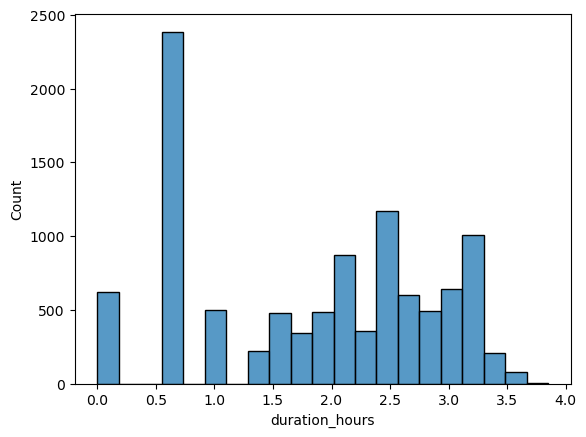

<Figure size 640x480 with 0 Axes>

In [53]:
print('after logging the values : ')
print()
log=['price','duration_hours']
for i in log:
    sns.histplot(x=np.log(df[i]))
    plt.figure()

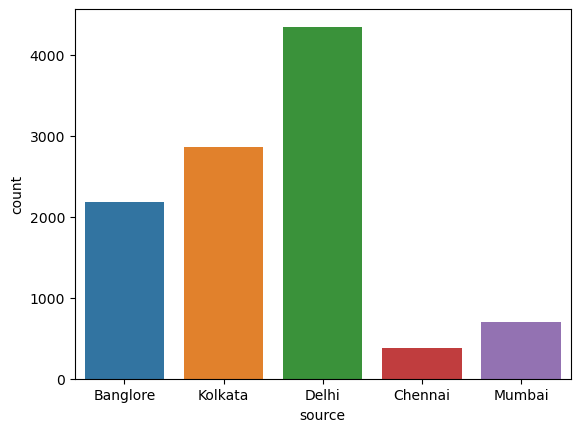

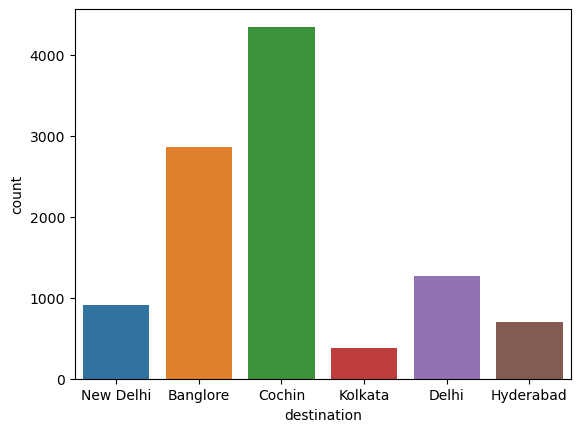

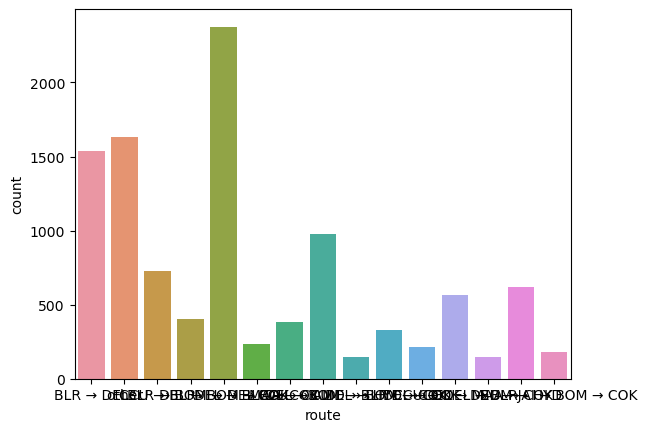

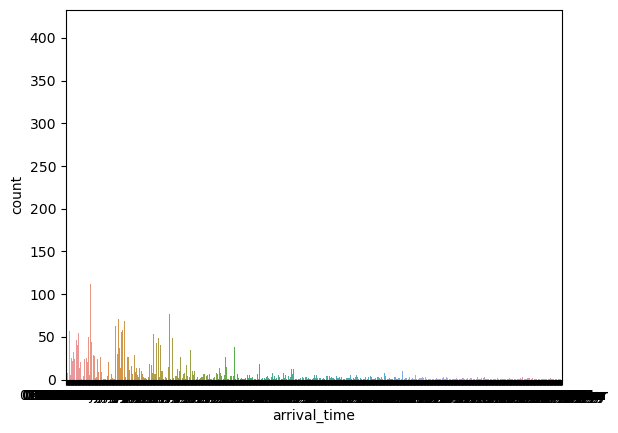

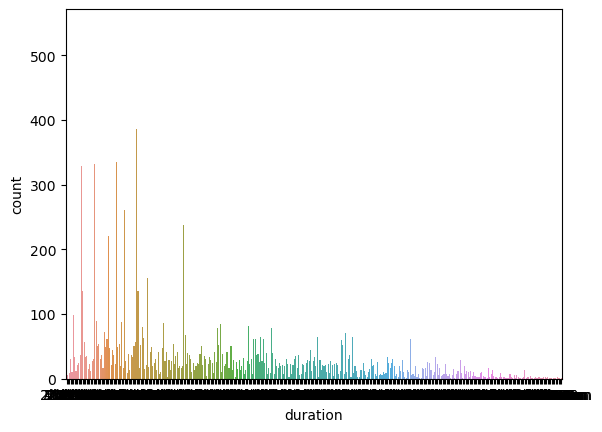

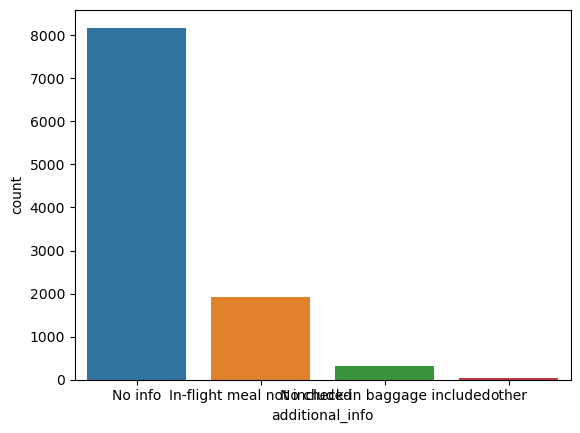

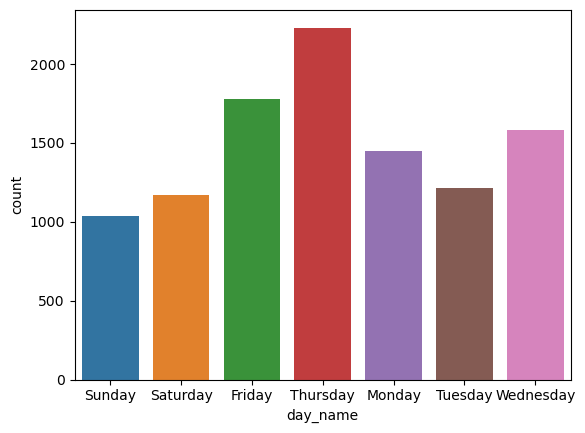

<Figure size 640x480 with 0 Axes>

In [54]:
#object features
for i in df.select_dtypes(include='O').columns:
    sns.countplot(x=df[i])
    plt.figure()
print() 

In [55]:
#drop unnecessary columns
df.columns

Index(['airline', 'source', 'destination', 'route', 'dep_time', 'arrival_time',
       'duration', 'total_stops', 'additional_info', 'price', 'year', 'month',
       'day', 'day_name', 'duration_hours', 'duration_monutes'],
      dtype='object')

In [56]:
df.drop(['dep_time', 'arrival_time',
       'duration'],axis=1,inplace=True)

In [63]:
#bi variate analysis
#all features vs price
for i in df.columns :
    fig=px.scatter(df,x=df[i],y='price',color_discrete_sequence=['red'],title=f'{i} vs price')
    fig.show()

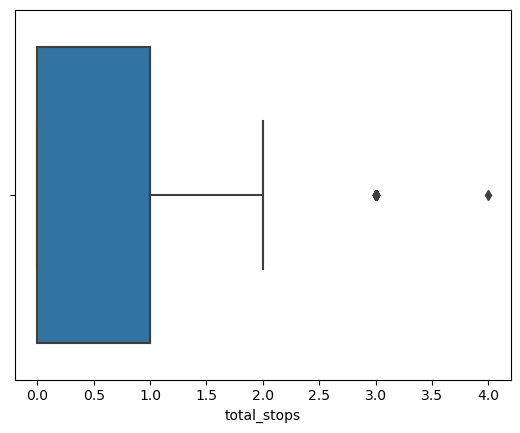

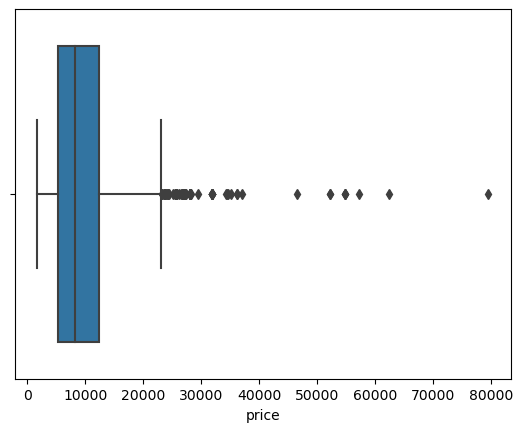

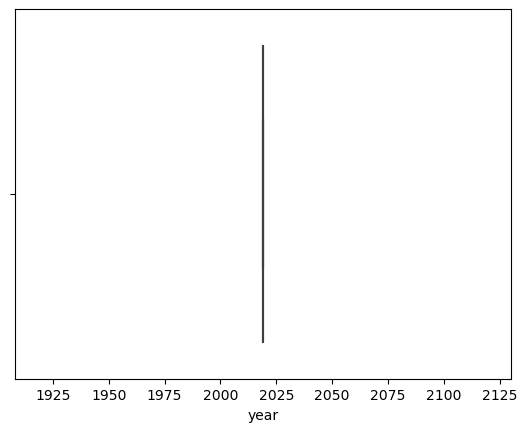

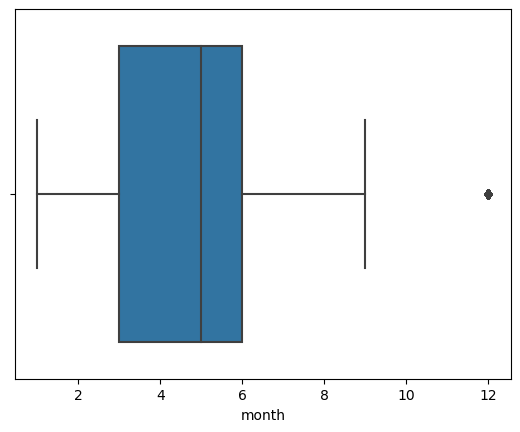

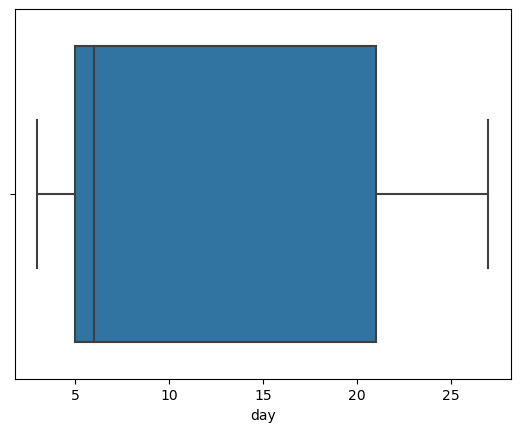

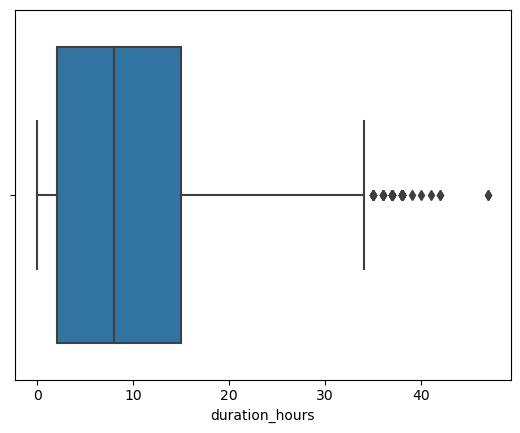

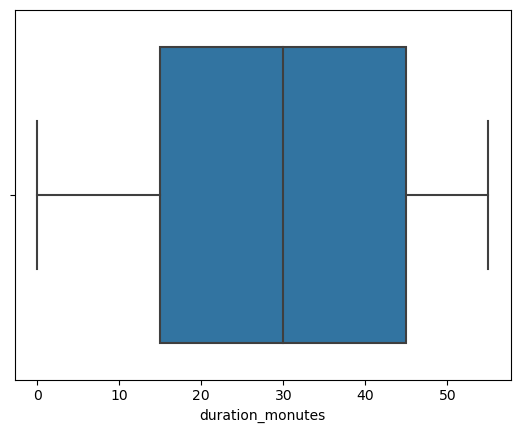

<Figure size 640x480 with 0 Axes>

In [65]:
#detect and handle outliers
#detect 
for i in df.select_dtypes(include="number").columns:
    sns.boxplot(x=df[i])
    plt.figure()

In [67]:
#handle outliers
indexes=detect_outliers(df,0,df[['duration_hours']])
len(indexes)

67

In [68]:
df.drop(indexes,axis=0,inplace=True)
df.reset_index(inplace=True,drop=True)

In [69]:
df

airline    source destination      route  total_stops  \
0           IndiGo  Banglore   New Delhi  BLR → DEL            0   
1        Air India   Kolkata    Banglore      other            2   
2      Jet Airways     Delhi      Cochin      other            2   
3           IndiGo   Kolkata    Banglore      other            1   
4           IndiGo  Banglore   New Delhi      other            1   
...            ...       ...         ...        ...          ...   
10390     Air Asia   Kolkata    Banglore  CCU → BLR            0   
10391    Air India   Kolkata    Banglore  CCU → BLR            0   
10392  Jet Airways  Banglore       Delhi  BLR → DEL            0   
10393      Vistara  Banglore   New Delhi  BLR → DEL            0   
10394    Air India     Delhi      Cochin      other            2   

      additional_info  price  year  month  day   day_name  duration_hours  \
0             No info   3897  2019      3   24     Sunday               2   
1             No info   7662  2019      1    5   Saturday               7   
2             No info  13882  2019      9    6     Friday              19   
3             No info   6218  2019     12    5   Thursday               5   
4             No info  13302  2019      1    3   Thursday               4   
...               ...    ...   ...    ...  ...        ...             ...   
10390         No info   4107  2019      9    4  Wednesday               2   
10391         No info   4145  2019      4   27   Saturday               2   
10392         No info   7229  2019      4   27   Saturday               3   
10393         No info  12648  2019      1    3   Thursday               2   
10394         No info  11753  2019      9    5   Thursday               8   

       duration_monutes  
0                    50  
1                    25  
2                     0  
3                    25  
4                    45  
...                 ...  
10390                30  
10391                35  
10392                 0  
10393                40  
10394                20  

[10395 rows x 13 columns]

<AxesSubplot:>

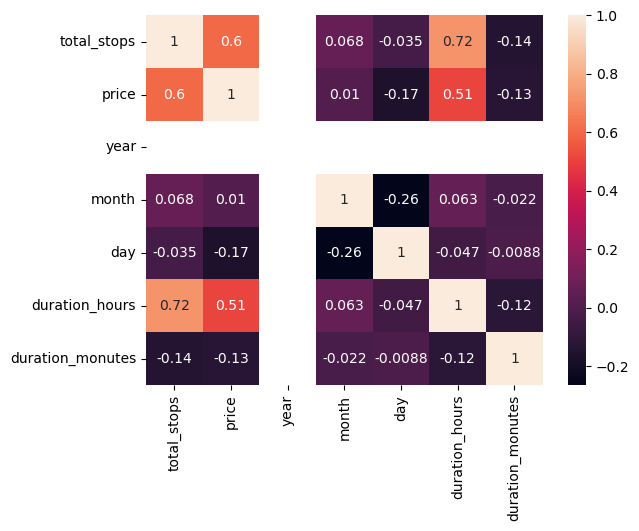

In [71]:
#correlation
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True )

In [72]:
#drop unnecessary columns that not needed in our regression
df.drop(['day' , 'day_name'] , axis = 1 , inplace = True )

In [74]:
#encoding with pipeline
#work with categorical data 
#check and decide the encoding stategy
#update objects list
lst_obj=[]
for i in df.select_dtypes(include="O").columns :
    lst_obj.append(i)
for i in lst_obj:
    print(f"for feature {i} : ",df[i].nunique())
    print()

for feature airline :  9

for feature source :  5

for feature destination :  6

for feature route :  15

for feature additional_info :  4



In [75]:
#one hot encoding
lst_small=['source','destination','additional_info']
ohe = OneHotEncoder(sparse=False )
ohe.fit_transform(df[lst_small])
df_ohe = pd.DataFrame(ohe.fit_transform(df[lst_small]) , columns=ohe.get_feature_names_out())
df = pd.concat([df , df_ohe ] , axis = 1)
df.drop(lst_small , axis = 1 , inplace = True )
df

airline      route  total_stops  price  year  month  \
0           IndiGo  BLR → DEL            0   3897  2019      3   
1        Air India      other            2   7662  2019      1   
2      Jet Airways      other            2  13882  2019      9   
3           IndiGo      other            1   6218  2019     12   
4           IndiGo      other            1  13302  2019      1   
...            ...        ...          ...    ...   ...    ...   
10390     Air Asia  CCU → BLR            0   4107  2019      9   
10391    Air India  CCU → BLR            0   4145  2019      4   
10392  Jet Airways  BLR → DEL            0   7229  2019      4   
10393      Vistara  BLR → DEL            0  12648  2019      1   
10394    Air India      other            2  11753  2019      9   

       duration_hours  duration_monutes  source_Banglore  source_Chennai  ...  \
0                   2                50              1.0             0.0  ...   
1                   7                25              0.0             0.0  ...   
2                  19                 0              0.0             0.0  ...   
3                   5                25              0.0             0.0  ...   
4                   4                45              1.0             0.0  ...   
...               ...               ...              ...             ...  ...   
10390               2                30              0.0             0.0  ...   
10391               2                35              0.0             0.0  ...   
10392               3                 0              1.0             0.0  ...   
10393               2                40              1.0             0.0  ...   
10394               8                20              0.0             0.0  ...   

       destination_Banglore  destination_Cochin  destination_Delhi  \
0                       0.0                 0.0                0.0   
1                       1.0                 0.0                0.0   
2                       0.0                 1.0                0.0   
3                       1.0                 0.0                0.0   
4                       0.0                 0.0                0.0   
...                     ...                 ...                ...   
10390                   1.0                 0.0                0.0   
10391                   1.0                 0.0                0.0   
10392                   0.0                 0.0                1.0   
10393                   0.0                 0.0                0.0   
10394                   0.0                 1.0                0.0   

       destination_Hyderabad  destination_Kolkata  destination_New Delhi  \
0                        0.0                  0.0                    1.0   
1                        0.0                  0.0                    0.0   
2                        0.0                  0.0                    0.0   
3                        0.0                  0.0                    0.0   
4                        0.0                  0.0                    1.0   
...                      ...                  ...                    ...   
10390                    0.0                  0.0                    0.0   
10391                    0.0                  0.0                    0.0   
10392                    0.0                  0.0                    0.0   
10393                    0.0                  0.0                    1.0   
10394                    0.0                  0.0                    0.0   

       additional_info_In-flight meal not included  \
0                                              0.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   
...                                            ...   
10390                                          0.0   
10391                                          0.0   
10392

In [77]:
#binary encoding
lst_big=['airline','route']
for i in lst_big :
    ce_bin=BinaryEncoder()
    y=ce_bin.fit_transform(df[[i]])
    df=pd.concat([df,y],axis=1)
    df.drop([i],axis=1,inplace=True)  
df

total_stops  price  year  month  duration_hours  duration_monutes  \
0                0   3897  2019      3               2                50   
1                2   7662  2019      1               7                25   
2                2  13882  2019      9              19                 0   
3                1   6218  2019     12               5                25   
4                1  13302  2019      1               4                45   
...            ...    ...   ...    ...             ...               ...   
10390            0   4107  2019      9               2                30   
10391            0   4145  2019      4               2                35   
10392            0   7229  2019      4               3                 0   
10393            0  12648  2019      1               2                40   
10394            2  11753  2019      9               8                20   

       source_Banglore  source_Chennai  source_Delhi  source_Kolkata  ...  \
0                  1.0             0.0           0.0             0.0  ...   
1                  0.0             0.0           0.0             1.0  ...   
2                  0.0             0.0           1.0             0.0  ...   
3                  0.0             0.0           0.0             1.0  ...   
4                  1.0             0.0           0.0             0.0  ...   
...                ...             ...           ...             ...  ...   
10390              0.0             0.0           0.0             1.0  ...   
10391              0.0             0.0           0.0             1.0  ...   
10392              1.0             0.0           0.0             0.0  ...   
10393              1.0             0.0           0.0             0.0  ...   
10394              0.0             0.0           1.0             0.0  ...   

       additional_info_No info  additional_info_other  airline_0  airline_1  \
0                          1.0                    0.0          0          0   
1                          1.0                    0.0          0          0   
2                          1.0                    0.0          0          0   
3                          1.0                    0.0          0          0   
4                          1.0                    0.0          0          0   
...                        ...                    ...        ...        ...   
10390                      1.0                    0.0          1          0   
10391                      1.0                    0.0          0          0   
10392                      1.0                    0.0          0          0   
10393                      1.0                    0.0          0          1   
10394                      1.0                    0.0          0          0   

       airline_2  airline_3  route_0  route_1  route_2  route_3  
0              0          1        0        0        0        1  
1              1          0        0        0        1        0  
2              1          1        0        0        1        0  
3              0          1        0        0        1        0  
4              0          1        0        0        1        0  
...          ...        ...      ...      ...      ...      ...  
10390          0          0        0        0        1        1  
10391          1          0        0        0        1        1  
10392          1          1        0        0        0        1  
10393          1          1        0        0        0        1  
10394          1          0        0        0        1        0  

[10395 rows x 29 columns]

In [81]:
#split data
x=df.drop('price',axis=1)
y=df['price']

In [82]:
x

total_stops  year  month  duration_hours  duration_monutes  \
0                0  2019      3               2                50   
1                2  2019      1               7                25   
2                2  2019      9              19                 0   
3                1  2019     12               5                25   
4                1  2019      1               4                45   
...            ...   ...    ...             ...               ...   
10390            0  2019      9               2                30   
10391            0  2019      4               2                35   
10392            0  2019      4               3                 0   
10393            0  2019      1               2                40   
10394            2  2019      9               8                20   

       source_Banglore  source_Chennai  source_Delhi  source_Kolkata  \
0                  1.0             0.0           0.0             0.0   
1                  0.0             0.0           0.0             1.0   
2                  0.0             0.0           1.0             0.0   
3                  0.0             0.0           0.0             1.0   
4                  1.0             0.0           0.0             0.0   
...                ...             ...           ...             ...   
10390              0.0             0.0           0.0             1.0   
10391              0.0             0.0           0.0             1.0   
10392              1.0             0.0           0.0             0.0   
10393              1.0             0.0           0.0             0.0   
10394              0.0             0.0           1.0             0.0   

       source_Mumbai  ...  additional_info_No info  additional_info_other  \
0                0.0  ...                      1.0                    0.0   
1                0.0  ...                      1.0                    0.0   
2                0.0  ...                      1.0                    0.0   
3                0.0  ...                      1.0                    0.0   
4                0.0  ...                      1.0                    0.0   
...              ...  ...                      ...                    ...   
10390            0.0  ...                      1.0                    0.0   
10391            0.0  ...                      1.0                    0.0   
10392            0.0  ...                      1.0                    0.0   
10393            0.0  ...                      1.0                    0.0   
10394            0.0  ...                      1.0                    0.0   

       airline_0  airline_1  airline_2  airline_3  route_0  route_1  route_2  \
0              0          0          0          1        0        0        0   
1              0          0          1          0        0        0        1   
2              0          0          1          1        0        0        1   
3              0          0          0          1        0        0        1   
4              0          0          0          1        0        0        1   
...          ...        ...        ...        ...      ...      ...      ...   
10390          1          0          0          0        0        0        1   
10391          0          0          1          0        0        0        1   
10392          0          0          1          1        0        0        0   
10393          0          1          1          1        0        0        0   
10394          0          0          1          0        0        0        1   

       route_3  
0            1  
1            0  
2            0  
3            0  
4            0  
...        ...  
10390        1  
10391        1  
10392        1  
10393        1  
10394        0  

[10395 rows x 28 columns]

In [83]:
y

0         3897
1         7662
2        13882
3         6218
4        13302
         ...  
10390     4107
10391     4145
10392     7229
10393    12648
10394    11753
Name: price, Length: 10395, dtype: int64

In [98]:
#create pipeline for  scaling  then your preferred model
#create stander scaler object
Models = [
    ('lr' , LinearRegression()),
    ('lasso' , Lasso()),
    ('ridge' , Ridge()),
    #('svm' , SVR()),
    ('DT' , DecisionTreeRegressor()),
    ('RF' , RandomForestRegressor()),
    ('XGB' , XGBRegressor())
]

In [163]:
#create pipeline for scaling then  your preferred model
#create stander scaler object
#fitting models
for model in Models :
    #fit
    pipline=make_pipeline(StandardScaler(),model[1])
    print(f'for model {model[0]} : ')
    print()
    scores=cross_validate(estimator=pipline,X=x,y=y,cv=5,return_train_score=True,return_estimator=True)
    print('average of train scores : ',np.around(scores['train_score'].mean(),2))
    print('average of test scores : ',np.around(scores['test_score'].mean(),2))
    print('average of fit time  : ',np.around(scores['fit_time'].mean(),2),'s')

for model lr : 

average of train scores :  0.6
average of test scores :  0.59
average of fit time  :  0.05 s
for model lasso : 

average of train scores :  0.6
average of test scores :  0.59
average of fit time  :  0.42 s
for model ridge : 

average of train scores :  0.6
average of test scores :  0.59
average of fit time  :  0.05 s
for model DT : 

average of train scores :  0.93
average of test scores :  0.62
average of fit time  :  0.09 s
for model RF : 

average of train scores :  0.91
average of test scores :  0.74
average of fit time  :  3.84 s
for model XGB : 

average of train scores :  0.89
average of test scores :  0.78
average of fit time  :  0.44 s
